
## Optimize and compare HuggingFace model inference on CPU and Inferentia

# Table of contents
1. [Introduction](#introduction)
    1. [Setting up the environment](#setenv)
3. [Get model from HuggingFace Model Hub](#getmodel)
    1. [Get the Tokenizer](#gettoken)
    2. [Download models and prepare them for inference](#trace)
4. [Deploy default model to a CPU-based endpoint](#deploycpu)
    1. [Perform a test CPU based inference](#testcpu)
5. [Compile and deploy the model on an Inferentia instance](#compiledeploy)
    1. [Review changes to the inference code](#reviewchanges)
    2. [Create and compile Pytorch model for the inf1 instance](#pytorchmodel)
    3. [Deploy compiled model into the inf1 instance](#deployinf1)
    4. [Perform a test inf1 based inference](#testinf1)
6. [Benchmark and comparison](#benchmark)
    1. [Benchmark CPU based endpoint](#benchcpu)
    2. [Benchmark Inferentia based endpoint](#benchinf1)
7. [Comparison and conclusions](#conclusions)
8. [Cleanup](#cleanup)

---

# 1. Introduction <a name="introduction"></a>

During this workshop, we will create two endpoints with one HuggingFace model each. We will use them for the task of paraphrase detection which is an NLP classification problem. 
These two endpoints will have the following configurations: a) CPU-based endpoint, where we will be deploying the model with no changes; and b) Inf1 instance based endpoint, where we will prepare and compile the model using SageMaker Neo before deploying. 
Finally, we will perform a latency and throughput performance comparison of both endpoints. 

[AWS Inferentia](https://aws.amazon.com/machine-learning/inferentia/) is Amazon's first ML chips designed to accelerate deep learning workloads and is part of a long-term strategy to deliver on this vision. AWS Inferentia is designed to provide high performance inference in the cloud, to drive down the total cost of inference, and to make it easy for developers to integrate machine learning into their business applications. AWS Inferentia chips deliver up 2.3x higher throughput and up to 70% lower cost per inference than comparable current generation GPU-based Amazon EC2 instances, as we will confirm in the example notebook.

[AWS Neuron](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/) is a software development kit (SDK) for running machine learning inference using AWS Inferentia chips. It consists of a compiler, run-time, and profiling tools that enable developers to run high-performance and low latency inference using AWS Inferentia-based Amazon EC2 Inf1 instances. Using Neuron, you can bring your models that have been trained on any popular framework (PyTorch, TensorFlow, MXNet), and run them optimally on Inferentia. There is excellent support for Vision and NLP models especially, and on top of that we have released great features to help you make the most efficient use of the hardware, such as [dynamic batching](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/appnotes/perf/torch-neuron-dataparallel-app-note.html#dynamic-batching-description) or [Data Parallel](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-torch-neuron-dataparallel-api.html) inferencing.

[SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) saves you the effort of DIY model compilation, extending familiar SageMaker SDK API's to enable easy compilation for a [wide range](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents) of platforms. This includes CPU and GPU-based instances, but also Inf1 instances; in this case, SageMaker Neo uses the Neuron SDK to compile your model.


---

### Environment Set Up <a name="setenv"></a>
First, make sure you are using the Python 3 (Pytorch 1.8 Python 3.6 CPU Optimized) Kernel. And that you are working in the us-west-2 region unless instructed otherwise.

Then, install ipywidgets library and restart the kernel to be able to use it.

In [1]:
# %%capture
# import IPython
# import sys

# !{sys.executable} -m pip install ipywidgets
# IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

STOP! Restart the Kernel, comment the cell above and continue.

We will then install required Python packages. Also, we will create a default Amazon Sagemaker session, get the Amazon Sagemaker role and default Amazon S3 bucket.

In [2]:
%%capture
!pip install -U transformers
!pip install -U sagemaker
!pip install -U torch

In [3]:
import sys
import transformers
import sagemaker
import torch
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sess_bucket = sagemaker_session.default_bucket()

---

## 2. Get model from HuggingFace Model Hub <a name="getmodel"></a>

For this workshop, we will use [Prompsit/paraphrase-bert-en](https://huggingface.co/Prompsit/paraphrase-bert-en) transformer model from HuggingFace Model Hub. It has been fine-tuned from a pretrained model called "bert-base-uncased". The model works comparing a pair of sentences, it determines the semantic similarity between them. If the two sentences convey the same meaning it is labelled as paraphrase, otherwise it is labeled as non-paraphrase. 
So it allows to evaluate paraphrases for a given phrase, answering the following question: Is "phrase B" a paraphrase of "phrase A"? and the resulting probabilities correspond to classes:

    0: Not a paraphrase
    1: It's a paraphrase

This model doesn't expect to find punctuation marks or long pieces of text.


### Get the Tokenizer <a name="gettoken"></a>
As a first step, we need to get the tokenizer. A tokenizer breaks a stream of text into tokens, and it is in charge of preparing the inputs for a model. We need it to create a sample input to interact with the model, and will get it from HuggingFace through the `transformers` library. It is important to set the `return_dict` parameter to `False` when instantiating the model. In `transformers` v4.x, this parameter is `True` by default and it enables the return of dict-like python objects containing the model outputs, instead of the standard tuples. Neuron compilation does not support dictionary-based model ouputs, and compilation would fail if we didn't explictly set it to `False`.

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained("Prompsit/paraphrase-bert-en")

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "Prompsit/paraphrase-bert-en", return_dict=False
)

### Download models and prepare them for inference <a name="trace"></a>
We will download the model and create two files with different formats. The first one is the model itself with no changes. This one will be uploaded and used in the CPU based endpoint as it is. The second image is a traced Pytorch image of the model so we can compile it before deploying it to the inf1 instance.

PyTorch models must be saved as a definition file (.pt or .pth) with input datatype of float32.
To save the model, we will use torch.jit.trace followed by torch.save. This will save an object to a file ( a python pickle: pickle_module=pickle). 

Next, we will convert the saved model to a compressed tar file and upload it to an S3 bucket.
As a final step, we will create a sample input to `jit.trace` of the model with PyTorch. We need this to have SageMaker Neo compile the model artifact.


In [5]:
from pathlib import Path

# Create directory for model artifacts
Path("normal_model/").mkdir(exist_ok=True)
Path("traced_model/").mkdir(exist_ok=True)

# Prepare sample input for jit model tracing
seq_0 = "The Internet is an international form and opinion might differ on how it should be regulated in some ways, but everyone should be in agreement on child abuse and pornography laws. Assessing the need to safeguard minors with the requirement to preserve freedom of expression is a difficult problem."
seq_1 = seq_0
max_length = 512

tokenized_sequence_pair = tokenizer.encode_plus(
    seq_0, seq_1, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
)

example = tokenized_sequence_pair["input_ids"], tokenized_sequence_pair["attention_mask"]

traced_model = torch.jit.trace(model.eval(), example)

model.save_pretrained('normal_model/')
traced_model.save("traced_model/model.pth") # The `.pth` extension is required.

In [6]:
!tar -czvf normal_model.tar.gz -C normal_model . && mv normal_model.tar.gz normal_model/
!tar -czvf traced_model.tar.gz -C traced_model . && mv traced_model.tar.gz traced_model/

./
./pytorch_model.bin
./config.json
./normal_model.tar.gz
./
./model.pth
./traced_model.tar.gz


We upload the traced model `tar.gz` file to Amazon S3, where the compilation job will download it from

In [7]:
normal_model_url = sagemaker_session.upload_data(
    path="normal_model/normal_model.tar.gz",
    key_prefix="neuron-experiments/bert-seq-classification/normal-model",
)

traced_model_url = sagemaker_session.upload_data(
    path="traced_model/traced_model.tar.gz",
    key_prefix="neuron-experiments/bert-seq-classification/traced-model",
)

---

## 3. Deploy default model to a CPU-based endpoint <a name="deploycpu"></a>

As a first step, we create model from the Hugging Face Model Class.
We will be passing the `normal_model_url` as the `model_data` parameter to the `HuggingFaceModel` API. 
Notice that we are passing `inference.py` as the entry point script; also, the packages defined in the requirements file within the `source_dir` will automatically be installed in the endpoint instance. In this case we will use the `transformers` library that is compatible Inferentia instances (v. 4.15.0)

In [8]:
!pygmentize code inference.py

usage: pygmentize [-l LEXER | -g] [-F FILTER[:options]] [-f FORMATTER]
                  [-O OPTION=value[,OPTION=value,...]] [-P OPTION=value]
                  [-o OUTPUTFILE] [-v] [-s] [-x] [--json]
                  [-S STYLE -f formatter | -L [WHAT [WHAT ...]] | -N FILENAME
                  | -C | -H NAME TYPE | -V | -h] [-a ARG]
                  [INPUTFILE]
pygmentize: error: unrecognized arguments: inference.py


In [9]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.predictor import Predictor
from datetime import datetime

prefix = "neuron-experiments/bert-seq-classification"
flavour = "normal"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

normal_sm_model = HuggingFaceModel(
    model_data=normal_model_url,
    predictor_cls=Predictor,
    transformers_version="4.12.3",
    pytorch_version='1.9.1',
    role=role,
    entry_point="inference.py",
    source_dir="code",
    py_version="py38",
    name=f"{flavour}-distilbert-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

Then, we create the endpoint and deploy the model for inference. This process will take about 4 minutes to complete. As you can see, one line of code will create a [real time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) for real time inference that you can integrate to your applications. These endpoints are fully managed and support autoscaling. 

In [10]:
%%time
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

hardware = "c5"

normal_predictor = normal_sm_model.deploy(
    instance_type="ml.c5.xlarge",
    initial_instance_count=1,
    endpoint_name=f"paraphrase-bert-en-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

-----!CPU times: user 1min 40s, sys: 22 s, total: 2min 2s
Wall time: 4min 48s


### Perform a test inference <a name="testcpu"></a> on CPU

We will perform a quick test to see if the endpoint is responding as expected. We will send sample sequences.

In [11]:
# Predict with model endpoint
client = boto3.client('sagemaker')

#let's make sure it is up und running first
status = ""
while status != 'InService':
    endpoint_response = client.describe_endpoint(EndpointName=f"paraphrase-bert-en-{hardware}-{date_string}")
    status = endpoint_response['EndpointStatus']


# Send a payload to the endpoint and recieve the inference
payload = seq_0, seq_1
normal_predictor.predict(payload)

['"BERT predicts that \\"The Internet is an international form and opinion might differ on how it should be regulated in some ways, but everyone should be in agreement on child abuse and pornography laws. Assessing the need to safeguard minors with the requirement to preserve freedom of expression is a difficult problem.\\" and \\"The Internet is an international form and opinion might differ on how it should be regulated in some ways, but everyone should be in agreement on child abuse and pornography laws. Assessing the need to safeguard minors with the requirement to preserve freedom of expression is a difficult problem.\\" are paraphrase"',
 'application/json']

---

## 4. Compile and deploy the model on an Inferentia instance <a name="compiledeploy"></a>

In this section we will cover the compilation and deployment of the model into the inf1 instance. We will also review the changes in the inference code.

### Review inference code <a name="reviewchanges"></a>

If you open `inference.py` you will see a few functions: 
a) `model_fn` which receives the model directory and is responsible for loading and returning the model.
b) `input_fn` and `output_fn` functions that are in charge of pre-processing/checking content types of input and output to the endpoint.
And c) `predict_fn`, receives the outputs of `model_fn` and `input_fn` and defines how the model will run inference (it recieves the loaded model and the deserialized/pre-processed input data).
All of this code runs inside the endpoint once it is created.

In [12]:
!pygmentize code/inference.py

import os
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

JSON_CONTENT_TYPE = 'application/json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_fn(model_dir):
    tokenizer_init = AutoTokenizer.from_pretrained('Prompsit/paraphrase-bert-en')
    compiled_model = os.path.exists(f'{model_dir}/model.pth')
    if compiled_model:
        import torch_neuron
        os.environ["NEURONCORE_GROUP_SIZES"] = "1"
        model = torch.jit.load(f'{model_dir}/model.pth')
    else: 
        model = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
    
    return (model, tokenizer_init)


def input_fn(serialized_input_data, content_type=JSON_CONTENT_TYPE):
    if content_type == JSON_CONTENT_TYPE:
        input_data = json.loads(serialized_input_data)
        return input_data
    else:
        raise Exception('Requested unsupported ContentType in Accept: ' + content_type)
       

In this case, notice that we will load the corresponding model depending on where the function is deployed. `model_fn` will return a tuple containing both the model and its corresponding tokenizer. Both the model and the input data will be sent `.to(device)`, which can be a CPU or GPU.

Also, notice the `predict_fn`. In this function we recieve the string for inference, convert it to the format the model accepts, ask the model for the inference, recieve the inference and format it in clear text as a return string. In real life you might not need to do this interpretation since your application might be fine receiving the predicted class and use it directly.

### Create and compile Pytorch model for the inf1 instance <a name="pytorchmodel"></a>

We will now create a new `Huggingface` model that will use the `inference.py` file described above as its entry point script. 

In [13]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.predictor import Predictor
from datetime import datetime
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")
hardware = "inf1"
compilation_job_name = f"paraphrase-bert-en-{hardware}-" + date_string
output_model_path = f"s3://{sess_bucket}/{prefix}/neo-compilations19/{hardware}-model"

compiled_inf1_model = HuggingFaceModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    transformers_version="4.12.3",
    pytorch_version='1.9.1',
    role=role,
    entry_point="inference.py",
    source_dir="code",
    py_version="py37",
    name=f"distilbert-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

We are ready to compile the model! Two additional notes:
* HuggingFace models should be compiled to `dtype` `int64`
* the format for `compiler_options` differs from the standard Python `dict` that you can use when compiling for "normal" instance types; for inferentia, you must provide a JSON string with CLI arguments, which correspond to the ones supported by the [Neuron Compiler](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-cc/command-line-reference.html) (read more about `compiler_options` [here](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents))


#### Model compilation

Let's compile the model (this will take around 10 minutes to complete):

In [14]:
%%time
import json

compiled_inf1_model = compiled_inf1_model.compile(
    target_instance_family=f"ml_{hardware}",
    input_shape={"input_ids": [1, 512], "attention_mask": [1, 512]},
    job_name=compilation_job_name,
    role=role,
    framework="pytorch",
    framework_version="1.9.1",
    output_path=output_model_path,
    compiler_options=json.dumps("--dtype int64"),
    compile_max_run=900,
)

??????????????????????????????..................................................................................................................................!CPU times: user 547 ms, sys: 63.3 ms, total: 611 ms
Wall time: 13min 40s


#### Compiler logs and artifacts
Open a new browser tab and navigate to the Sagemaker Console. Under the Images menu on the left you will find the menu Inference and inside "Compilation Jobs". Here is where you will find the job that was executed in the previous cell. Look for the job name to get its details. If you scroll down you will find a section called "Monitor" you can access the compiler logs hosted in Cloudwatch. Look for the successful completion of the job in a line similar to the following:

Also, in the Output section, you will find a link to the S3 compiled model artifact. Click on it so see where it was stored.

In [15]:
print("Compilation job name: {} \nOutput model path in S3: {}".format(compilation_job_name, output_model_path))

Compilation job name: paraphrase-bert-en-inf1-202304-2704-0647 
Output model path in S3: s3://sagemaker-us-east-1-231891361855/neuron-experiments/bert-seq-classification/neo-compilations19/inf1-model


### Deploy compiled model into the inf1 instance <a name="deployinf1"></a>

After successful compilation, we deploy the new model to an inf1.xlarge instance based  [real time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html). As you can see, the one line of code procedure is similar to creating a CPU based instance. 

In [16]:
%%time

compiled_inf1_predictor = compiled_inf1_model.deploy(
    instance_type="ml.inf1.xlarge",
    initial_instance_count=1,
    endpoint_name=f"paraphrase-bert-en-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=False
)

CPU times: user 13.1 s, sys: 2.31 s, total: 15.4 s
Wall time: 15.9 s


### Perform a test inference <a name="testinf1"></a>

As a final test, we first make sure the endpoint is up una running in a `InService` state, and then perform a simple inference sending two sequences of text and wait for the response.

In [17]:
# Predict with model endpoint
client = boto3.client('sagemaker')

#let's make sure it is up und running first
status = ""
while status != 'InService':
    endpoint_response = client.describe_endpoint(EndpointName=f"paraphrase-bert-en-{hardware}-{date_string}")
    status = endpoint_response['EndpointStatus']


# Send a payload to the endpoint and recieve the inference
payload = seq_0, seq_1
compiled_inf1_predictor.predict(payload)

'BERT predicts that "The Internet is an international form and opinion might differ on how it should be regulated in some ways, but everyone should be in agreement on child abuse and pornography laws. Assessing the need to safeguard minors with the requirement to preserve freedom of expression is a difficult problem." and "The Internet is an international form and opinion might differ on how it should be regulated in some ways, but everyone should be in agreement on child abuse and pornography laws. Assessing the need to safeguard minors with the requirement to preserve freedom of expression is a difficult problem." are paraphrase'

---

## 5. Benchmark and comparison <a name="benchmark"></a>

Now that we have both endpoints online, we will perform a benchmark using Python's `threading` module. In each benchmark, we start 5 threads that will each make 100 requests to the model endpoint. We measure the inference latency for each request, and we also measure the total time to finish the task, so that we can get an estimate of the request throughput/second.

### Benchmark CPU based endpoint <a name="benchcpu"></a>

In [18]:
%%time
# Run the benchmark 

import threading
import time

num_preds = 100
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = normal_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Wait for threads, get an estimate of total time
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 140700087736064 startedThread 140700108715776 started

Thread 140700490401536 startedThread 140700500891392 started

Thread 140700479911680 started
CPU times: user 1.1 s, sys: 48.3 ms, total: 1.15 s
Wall time: 4min 25s


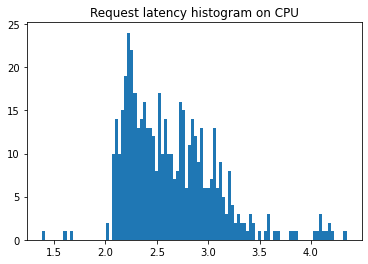

==== Default HuggingFace model on CPU benchmark ====

95 % of requests take less than 3418.834829330444 ms
Rough request throughput/second is 1.8856634508127772


In [19]:
# Display results 
from matplotlib.pyplot import hist, title, show, xlim
import numpy as np

TPS_CPU = (num_preds * num_threads) / end

t_CPU = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t_CPU, q=[50, 90, 95, 99])
latency_CPU = latency_percentiles[2]*1000

hist(t_CPU, bins=100)
title("Request latency histogram on CPU")
show()

print("==== Default HuggingFace model on CPU benchmark ====\n")
print(f"95 % of requests take less than {latency_CPU} ms")
print(f"Rough request throughput/second is {TPS_CPU}")

We can see that request latency is in the 1-1.2 second range, and throughput is ~4.5 TPS.

### Benchmark Inferentia based endpoint <a name="benchinf1"></a>

In [20]:
%%time
# Run benchmark 

import threading
import time


num_preds = 300
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = compiled_inf1_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Make a rough estimate of total time, wait for threads
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 140700479911680 started
Thread 140700490401536 started
Thread 140700087736064 startedThread 140700459472640 started

Thread 140700108715776 started
CPU times: user 2.15 s, sys: 109 ms, total: 2.26 s
Wall time: 15.4 s


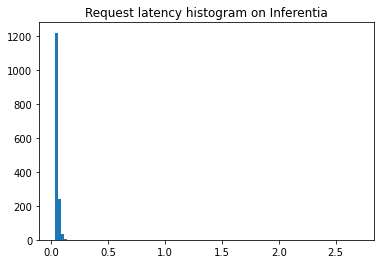

==== Default HuggingFace model on inf1 benchmark ====

95 % of requests take less than 75.17067193984985 ms
Rough request throughput/second is 97.46337081241705


In [21]:
# Display results 
from matplotlib.pyplot import hist, title, show, xlim
import numpy as np

TPS_inf1 = (num_preds * num_threads) / end

t_inf1 = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t_inf1, q=[50, 90, 95, 99])
latency_inf1 = latency_percentiles[2]*1000

hist(t_inf1, bins=100)
title("Request latency histogram on Inferentia")
show()

print("==== Default HuggingFace model on inf1 benchmark ====\n")
print(f"95 % of requests take less than {latency_inf1} ms")
print(f"Rough request throughput/second is {TPS_inf1}")




We can see that request latency is in the 0.02-0.05 millisecond range, and throughput is ~157 TPS.

---

# 6. Conclusion <a name="conclusions"></a>

In [22]:
print("Using inf1 instances latency dropped to a {:.2f} millisecond range from {:.2f} ms on a CPU endpoint.".format(latency_inf1, latency_CPU)) 
print("Also, The average throughput increased to {:.2f} TPS from {:.2f} TPS on the CPU.".format( TPS_inf1, TPS_CPU) )

Using inf1 instances latency dropped to a 75.17 millisecond range from 3418.83 ms on a CPU endpoint.
Also, The average throughput increased to 97.46 TPS from 1.89 TPS on the CPU.


This increase in performance obtained from using inf1 instances, paired with the cost reduction and the use of known SageMaker SDK APIs, enables new benefits with little development effort and a gentle learning curve. 

* To learn more about how to deploy Hugging Face modes through Sagemaker on to Inf1, please watch their latest [Webinar](https://www.youtube.com/watch?v=3fulTyMXhWQ), and read their latest [blog post](https://huggingface.co/blog/bert-inferentia-sagemaker). 
* For more information about Inferentia, please see the AWS EC2 Inf1 [website](https://aws.amazon.com/ec2/instance-types/inf1/) or check out other Tutorials available online [here] (https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-intro/tutorials.html).
* You can learn more about Inferentia performance on the [Neuron Inference Performance](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/benchmark/index.html) pages


---

# 7. Clean up <a name="cleanup"></a>
Delete the models and release the endpoints.

In [23]:
normal_predictor.delete_model()
normal_predictor.delete_endpoint()
compiled_inf1_predictor.delete_model()
compiled_inf1_predictor.delete_endpoint()